In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization
from keras import regularizers
from IPython.display import Image

In [9]:
dataset_dir = 'C:/Users/Test1/Desktop/Datavetenskap/YEAR3/ImageRecognition/Res'

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
img_height = 32
img_width = 32
batch_size = 128

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [12]:
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0) 
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

## Resnet Transfer Model

Our study implemented a transfer learning framework using the ResNet50 architecture, originally pre-trained on the ImageNet dataset, as a foundational model. To adapt ResNet50 for our binary classification task, we excluded the top fully connected layers (include_top=False), adjusting the network to receive input images of size 32x32 pixels. This configuration leverages the learned features from a comprehensive and diverse dataset, while tailoring the model to our specific needs.

Post the feature extraction through ResNet50, we appended a sequence of layers to further process these features: a batch normalization layer was first employed to stabilize and accelerate the model's training process by normalizing the activations. Following this, a densely connected layer with 256 units included regularization through L1 and L2 penalties to mitigate overfitting. A dropout layer was then incorporated to randomly omit 40% of the inputs during training, enhancing the model's ability to generalize. The architecture concluded with two additional dense layers, culminating in a final sigmoid activation layer for binary output, which classifies the images into two categories: 'FAKE' and 'REAL'.

In [13]:
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

ResNet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                           

In [14]:
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Epoch 1/20
782/782 [==============================] - 83s 95ms/step - loss: 1.3113 - accuracy: 0.9051 - precision_1: 0.9069 - recall_1: 0.9028 - val_loss: 0.3075 - val_accuracy: 0.9362 - val_precision_1: 0.9321 - val_recall_1: 0.9408
Epoch 2/20
782/782 [==============================] - 71s 90ms/step - loss: 0.2499 - accuracy: 0.9374 - precision_1: 0.9416 - recall_1: 0.9327 - val_loss: 2.8949 - val_accuracy: 0.5804 - val_precision_1: 0.9975 - val_recall_1: 0.1612
Epoch 3/20
782/782 [==============================] - 71s 90ms/step - loss: 0.1993 - accuracy: 0.9454 - precision_1: 0.9454 - recall_1: 0.9454 - val_loss: 0.1900 - val_accuracy: 0.9332 - val_precision_1: 0.9755 - val_recall_1: 0.8887
Epoch 4/20
782/782 [==============================] - 69s 88ms/step - loss: 0.1741 - accuracy: 0.9510 - precision_1: 0.9462 - recall_1: 0.9563 - val_loss: 0.2112 - val_accuracy: 0.9381 - val_precision_1: 0.9547 - val_recall_1: 0.9198
Epoch 5/20
782/782 [==============================] - 72s 92ms/s

In [15]:
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

157/157 [==============================] - 5s 29ms/step - loss: 0.1368 - accuracy: 0.9568 - precision_1: 0.9574 - recall_1: 0.9561
Val Loss: 0.1368
Val Accuracy: 0.9568
Val Precision: 0.9574
Val Recall: 0.9561


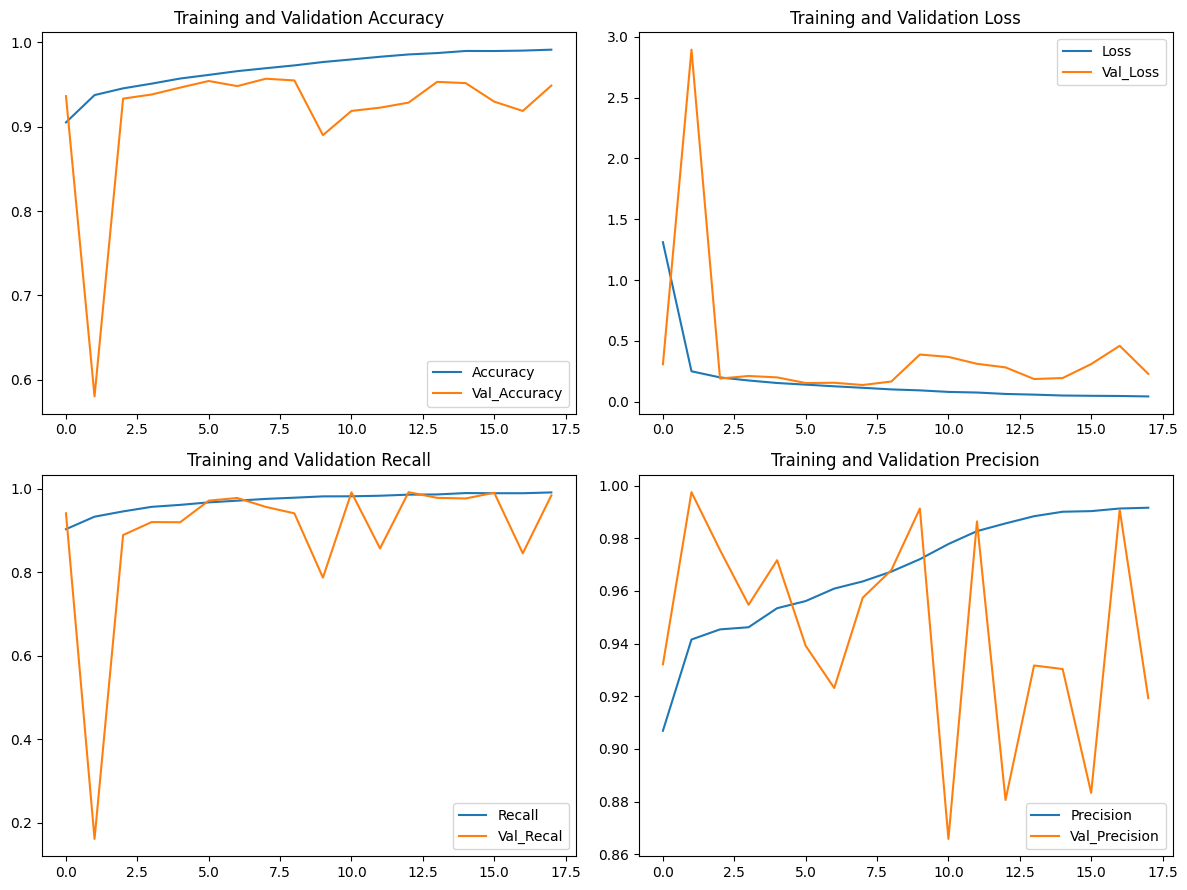

In [35]:
acc = ResNet_model_history.history['accuracy']
val_acc = ResNet_model_history.history['val_accuracy']
loss = ResNet_model_history.history['loss']
val_loss = ResNet_model_history.history['val_loss']
recall = ResNet_model_history.history['recall_1']
val_recall = ResNet_model_history.history['val_recall_1']
precision = ResNet_model_history.history['precision_1']
val_precision = ResNet_model_history.history['val_precision_1']

epochs_range = range(18)

plt.figure(figsize=(12, 9)) 
plt.subplot(2, 2, 1) 
plt.plot(epochs_range, acc, label='Accuracy') 
plt.plot(epochs_range, val_acc, label='Val_Accuracy')  
plt.legend(loc='lower right')  
plt.title('Training and Validation Accuracy')  

plt.subplot(2, 2, 2)  
plt.plot(epochs_range, loss, label='Loss') 
plt.plot(epochs_range, val_loss, label='Val_Loss')  
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss')  

plt.subplot(2, 2, 3)  
plt.plot(epochs_range, recall, label='Recall') 
plt.plot(epochs_range, val_recall, label='Val_Recal')  
plt.legend(loc='lower right') 
plt.title('Training and Validation Recall')  

plt.subplot(2, 2, 4)  
plt.plot(epochs_range, precision, label='Precision') 
plt.plot(epochs_range, val_precision, label='Val_Precision')  
plt.legend(loc='lower right') 
plt.title('Training and Validation Precision')  

plt.tight_layout()
plt.show() 

## Discussion

The visualized results depict the training and validation metrics for a deep learning model across epochs. The top-left graph represents accuracy, showing that the training accuracy is slightly higher than the validation accuracy throughout the epochs, indicating a slight overfitting as the model is performing better on the training data compared to new, unseen data. The top-right graph displays the loss, where we observe a sharp decline initially, which then stabilizes; this is typical as the model learns from the data. However, the validation loss shows more variability, suggesting that the model's predictions on the validation set have greater inconsistency.

The bottom-left graph illustrates recall, and the bottom-right shows precision. In both cases, the training metrics outperform the validation metrics, especially in precision, where the validation precision fluctuates more significantly. This could be due to the model learning to identify the positive class well but struggling to generalize this to the validation data. Interestingly, recall is relatively stable for validation, indicating the model's robustness in identifying all relevant instances in the validation set.

The numerical results provided at the end of training give us the final values after the last epoch: a training loss of 0.0429 with high accuracy, precision, and recall over 99%. The validation metrics are lower, with a loss of 0.2287, accuracy of 94.87%, precision at 91.93%, and recall at 98.37%. The high recall on the validation set suggests that the model is highly sensitive to the positive class, correctly identifying most of the positive samples. However, the lower precision indicates that there are more false positives, where the model predicts some negative samples as positive.

The significant gap between the training and validation precision (about 7%) could suggest that the model may be overfitting the training data, being too confident in its predictions, which do not generalize as well to the validation set. The results also demonstrate the trade-off between precision and recall, with high recall sometimes coming at the cost of reduced precision.